<h1>Week 2 Challenge: A/B Hypothesis Testing: Ad campaign performance</h1>

<h2>Project Overview </h2>

* SmartAd is a mobile first advertiser agency. It designs intuitive touch-enabled advertising.Their company is based on the principle of voluntary participation which is proven to increase brand engagement and memorability 10 x more than static alternatives. 
* SmartAd provides an additional service called Brand Impact Optimiser (BIO), a lightweight questionnaire, served with every campaign to determine the impact of the creative, the ad they design, on various upper funnel metrics, including memorability and brand sentiment. 

**Objective**

As a Machine learning engineer in SmartAd, one of your tasks is to design a reliable hypothesis testing algorithm for the BIO service and to determine whether a recent advertising campaign resulted in a significant lift in brand awareness.

SmartAd ran this campaign from 3-10 July 2020. The users that were presented with the questionnaire above were chosen according to the following rule: 

***Control:*** users who have been shown a dummy ad

***Exposed:***  users who have been shown a creative (ad) that was designed by SmartAd for the client. 

In [1]:
#Loading useful packages
import numpy as np
import pandas as pd
pd.set_option('max_column', None)
pd.set_option('display.float_format',lambda x:'%5f'%x)

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import streamlit as st

import warnings
warnings.filterwarnings('ignore')

import scipy
from scipy import stats

In [2]:
#Loading data
url='https://media.githubusercontent.com/media/katenjoki/AdCampaign/main/OneDrive/Desktop/10Academy/AdCampaign/data/AdSmartABdata.csv'
data=pd.read_csv(url)
data.head()

,auction_id,experiment,date,hour,device_make,platform_os,browser,yes,no
0,0008ef63-77a7-448b-bd1e-075f42c55e39,exposed,7/10/2020,8.000000,Generic Smartphone,6.000000,Chrome Mobile,0.000000,0.000000
1,000eabc5-17ce-4137-8efe-44734d914446,exposed,7/7/2020,10.000000,Generic Smartphone,6.000000,Chrome Mobile,0.000000,0.000000
2,0016d14a-ae18-4a02-a204-6ba53b52f2ed,exposed,7/5/2020,2.000000,E5823,6.000000,Chrome Mobile WebView,0.000000,1.000000
3,00187412-2932-4542-a8ef-3633901c98d9,control,7/3/2020,15.000000,Samsung SM-A705FN,6.000000,Facebook,0.000000,0.000000
4,001a7785-d3fe-4e11-a344-c8735acacc2c,control,7/3/2020,15.000000,Generic Smartphone,6.000000,Chrome Mobile,0.000000,0.000000


<h3>Dataset Dictionary</h3>

* auction_id: the unique id of the online user who has been presented the BIO. In standard terminologies this is called an impression id. The user may see the BIO questionnaire but choose not to respond. In that case both the yes and no columns are zero.
* experiment: which group the user belongs to - control or exposed.
* date: the date in YYYY-MM-DD format
* hour: the hour of the day in HH format.
* device_make: the name of the type of device the user has e.g. Samsung
* platform_os: the id of the OS the user has. 
* browser: the name of the browser the user uses to see the BIO questionnaire.
* yes: 1 if the user chooses the “Yes” radio button for the BIO questionnaire.


<h3>Data Preprocessing</h3>

In [3]:
#check for null values
#the data has no null values
data.isnull().any()

auction_id     False
experiment      True
date            True
hour            True
device_make     True
platform_os     True
browser         True
yes             True
no              True
dtype: bool

In [4]:
#check data types
data.dtypes

auction_id      object
experiment      object
date            object
hour           float64
device_make     object
platform_os    float64
browser         object
yes            float64
no             float64
dtype: object

In [5]:
#convert date column to datetime object
data['date']=pd.to_datetime(data['date'])

In [6]:
print('Number of unique device types:',data['device_make'].nunique())
print('\nUnique browsers:\n',data['browser'].unique())
print('\nUnique platforms,os:\n',data['platform_os'].unique())

Number of unique device types: 270

Unique browsers:
 ['Chrome Mobile' 'Chrome Mobile WebView' 'Facebook' 'Mobile Safari'
 'Chrome Mobile iOS' 'Samsung Internet' 'Mobile Safari UI/WKWebView'
 'Chrome' 'Opera Mini' 'Edge Mobile' 'Android' 'Pinterest' 'Opera Mobile'
 'Firefox Mobile' 'Puffin' nan]

Unique platforms,os:
 [ 6.  5.  7. nan]


In [7]:
data['platform_os'].nunique()

3

<h2>Task  1.2</h2>
<h3>Data Exploration</h3>

In [8]:
#Histogram
def plot_hist(df,col1):
    plt.figure(figsize=(10,8))
    plt.hist(df[col1],bins=20,color='#B0C485',edgecolor='#64894B',linewidth=0.5)
    plt.title(f'Histogram of {col1}', size=16,fontweight='bold')
    plt.show()
#Scatter plot
def plot_scatter(df,col1,col2):
    plt.figure(figsize=(12, 7))
    sns.scatterplot(data = df, x=col1, y=col2, hue=col1, style=col1)
    plt.title(f'{col1} vs {col2}', size=16)
    plt.xticks(fontsize=14)
    plt.yticks( fontsize=14)
    plt.show()
    
def plot_count(df,col1,col2):
    plt.figure(figsize=(12,8))
    
    plt.subplot(1,2,1)
    sns.countplot(data=df, x=col1,palette='summer')
    plt.title(f'Distribution of {col1}', size=16, fontweight='bold')
    plt.xticks(rotation=70)
    
    plt.subplot(1,2,2)
    sns.countplot(data=df, x=col2,palette='summer_r')
    plt.title(f'Distribution of {col2}', size=16, fontweight='bold')
    plt.xticks(rotation=70)
    plt.show()

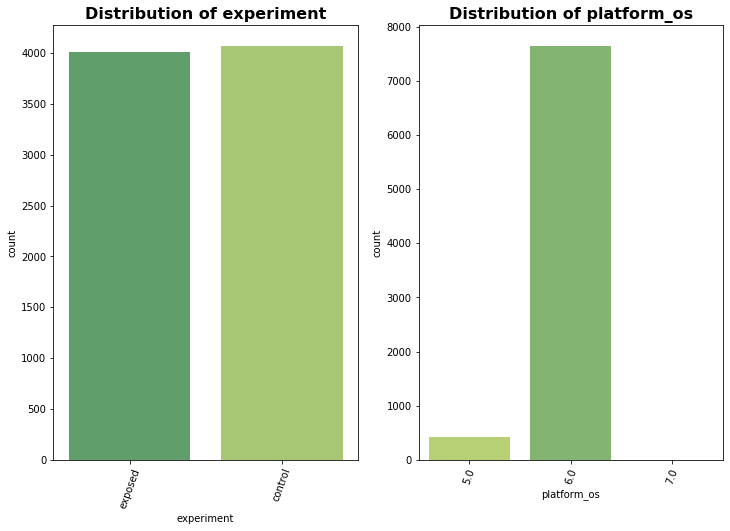

In [9]:
plot_count(data,'experiment','platform_os')

* The online users belonging to the exposed and control groups are equally distributed
* Most iOS users that were targeted by the campaign have a os version 6

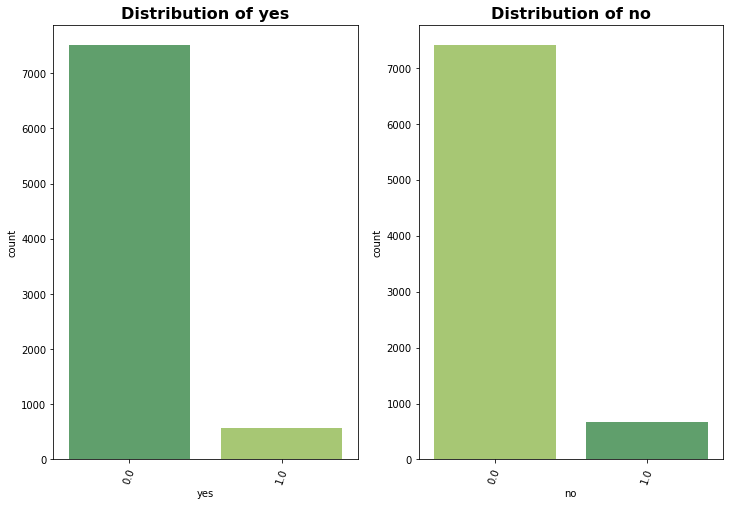

In [10]:
plot_count(data,'yes','no')

**Most users who came across the questionnaire didn't fill it**

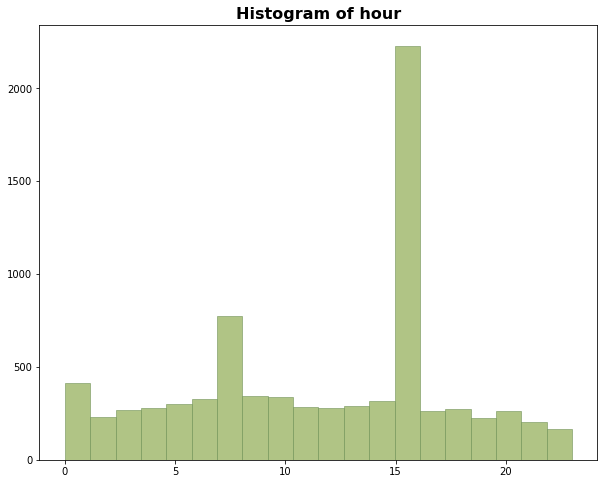

In [11]:
plot_hist(data,'hour')

**Most of the users filled the form between 4 and 5pm**

**To be able to see how many users interacted with the ads we create a new column where 0 means the user did not interact with the ad and 1 meaning they did i.e both Yes and No column values were 0**

* **The exposed group seems to have slightly more counts of yes than the exposed group.**
* **However, for both groups most people are still not aware of the brand**
* **We can't conclude based on the difference in counts of yes and no's of the 2 groups, that the SmartAd increased brand awareness**

<h2>Perform hypothesis testing: apply the classical p-value based algorithm and the  sequential A/B testing algorithm</h2>

**Null hypothesis:** there is no significant difference in brand awareness between the exposed and control groups in the current case

**Alternate hypothesis:** there is a significant difference in brand awareness between the exposed and control groups in the current case 

* To reject our null hypothesis, we have to prove that there is statistical significance 

* Given that the outcome of the questionnaire is binary, we use the chi-square test  and  Fisher's exact test to check whether the responses of the control and experiment groups were independent making their differences significant
* 5% is the significance

In [12]:
#Creating a contingency table with a summary of the observed outcomes
df=data.groupby('experiment').agg({'yes':'sum','no':'sum'})
df.loc['Total',:]=df.sum(axis=0)
df.loc[:,'Total']=df.sum(axis=1)
df.head()

,yes,no,Total
experiment,,,
control,264.000000,322.000000,586.000000
exposed,308.000000,349.000000,657.000000
Total,572.000000,671.000000,1243.000000


In [13]:
#Chi-square test of independence of variables
control_yes=df['yes'][0]
control_no=df['no'][0]
exposed_yes=df['yes'][1]
exposed_no=df['no'][1]

#create np array
T = np.array([[control_yes,control_no],[exposed_yes,exposed_no]])

print(scipy.stats.chi2_contingency(T,correction=False)[1])

0.518486498219898


**Fisher’s exact test is used to calculate the probability that proportions as or more extreme than the proportions we observed are caused by random chance**

In [14]:
import scipy.stats as stats

oddsratio, pvalue = stats.fisher_exact([[control_yes,control_no],[exposed_yes,exposed_no]])
pvalue

0.5309716576386057

* The p-value for the chi-square and Fisher's exact tests have been calculated to be 51.8% and 53.1% respectively. Assuming a 5% significance level, we fail to reject the null hypothesis and conclude that there is no significant difference in brand awareness between the exposed and control groups in the current case,  meaning brand awareness isn't increased for the exposed group


* The number of data points may not be enough to make a reasonable judgement, as out of the approximately 8000 users,only 1243 actually responded, so the experiment could be extended so as to get a more clear cut representation of the population. However, the p-value is very large assuming a significance level of 5%, hence chances of the p-value reducing significantly with an increase in the sample size are a bit slim